## 20110236 Ahmed Anwar  ML PA2

### 0. Loading Dependencies

In [439]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt

### 1. Data Preprocessing

#### 1.1 Defining directories

In [440]:
train_dir = 'Dataset/train/'
test_dir = 'Dataset/test/'

In [441]:
train_pos = glob.glob(train_dir+'/pos/*')
train_neg = glob.glob(train_dir+'/neg/*')
test_pos = glob.glob(test_dir+'/pos/*')

#### 1.2 Reading positive and negative corpus of words

In [442]:
positive = np.loadtxt('Dataset/positive-words.txt',dtype = str)
negative = np.loadtxt('Dataset/negative-words.txt',dtype = str)

print('Total Positve  words : ', len(positive))
print('Total Negative words : ', len(negative))

Total Positve  words :  2006
Total Negative words :  4783


#### 1.3 Function to clean a review

In [443]:
def clean_review(review):
    review = review.lower().replace(',','').replace('.','').replace('<br','').replace('/><br','').replace('/>','').replace(')','').replace('(','')
    review = review.replace(("\'"),("")).replace(";","").replace('  ',' ').replace('?',' ').replace('"', '')
    return review

#### 1.4 Function to generate features from a review

In [444]:
def get_features(path, pos_list = positive, neg_list = negative):
    
    f = open(path,"r",encoding="utf8")
    review = f.readline()
    f.close()
        
    #clean review
    review_clean = clean_review(review)
    
    
    # X1 count(positive words) ∈ review 
    pos_count = 0
    for i in pos_list:
        pos_count = pos_count + review.count(i) # <----------X1 
    x1 = pos_count
    
    # X2 count(negative words) ∈ review
    neg_count = 0
    for i in neg_list:
        neg_count = neg_count + review.count(i) # <----------X2
    x2 = neg_count
    
    
    # X3 Star Rating (1-10 scale) 
    start = path.find('_')+1
    end = path.find('.')
    x3 = int(path[start:end])                    # <----------X3
    
    # X4 log(word count of review)
    x4 = np.log(len(review.split()))    # <----------X4
    
    # X5 1 if “no” ∈ review, 0 otherwise
    x5 = 0   
    if "no" in review.split():                  # <----------X5        
        x5 = 1
    
    # X6 1 if “!” ∈ review, 0 otherwise
    x6 = 0
    if "!" in review:                           # <----------X6       
        x6 = 1
    
        
    return (x1,x2,x3,x4,x5,x6)

#### 1.5 Function to Build DataFrame from the reviews

In [445]:
def getData(directory):
    
    X1 = [] # count(positive words) ∈ review 
    X2 = [] # count(negative words) ∈ review
    X3 = [] # Star Rating (1-10 scale) 
    X4 = [] # log(word count of review)
    X5 = [] # 1 if “no” ∈ review, 0 otherwise
    X6 = [] # 1 if “!” ∈ review, 0 otherwise
    Y  = [] # 1 if positive, 0 otherwise
    
    
    positive_paths = glob.glob(directory +'/pos/*')
    negative_paths = glob.glob(directory +'/neg/*')
    
    #one for loop given that postive and negative reviews are of same length
    for i in range(len(positive_paths)):
        
        features = get_features(positive_paths[i])
        X1.append(features[0])
        X2.append(features[1])
        X3.append(features[2])
        X4.append(features[3])
        X5.append(features[4])
        X6.append(features[5])
        Y.append(1)
        
        features = get_features(negative_paths[i])
        X1.append(features[0])
        X2.append(features[1])
        X3.append(features[2])
        X4.append(features[3])
        X5.append(features[4])
        X6.append(features[5])
        Y.append(0)
    
    df = pd.DataFrame({
                       'X1': X1,
                       'X2': X2,
                       'X3': X3,
                       'X4': X4,
                       'X5': X5,
                       'X6': X6,
                       'Y' : Y
                      })
    return df

#### 1.6 Dump data sets to save time

In [446]:
%time train_set = getData(train_dir)
train_set.to_csv('train.csv',index=False)

Wall time: 10min 52s


In [447]:
%time test_set = getData(test_dir)
test_set.to_csv('test.csv',index=False)

Wall time: 9min 58s


### 2. Logistic Regression

####  2.1 Load data sets 

In [448]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

X_train = np.asarray(train.iloc[:,0:6]).reshape(len(X_train),6)
Y_train = np.asarray(train.iloc[:,6]).reshape(len(X_train),1)

X_test = np.asarray(test.iloc[:,0:6])
Y_test = np.asarray(test.iloc[:,6])

#### 2.2 Function to initialize the parameters

In [449]:
def initialize(features):
    #This function initialies the weights randomly according to specific shape
    weights = np.random.normal(size = (features.shape[1],1))
    bias = 0
    parameters = {'weights':weights, 'bias':bias}
    return parameters

#### 2.3 Sigmoid Activation function

In [450]:
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

#### 2.4 Function to normalize data

In [451]:
def normalize(features):
    #to speed up weight update process
    mean = np.mean(features, axis = 0)
    std = np.std(features, axis = 0)
    features_norm = (features-mean)/std
    return features_norm

#### 2.5 Prediction Function

In [452]:
def predict(features, parameters):
    W = parameters['weights']
    b = parameters['bias']
    z = np.dot(features, W) + b
    return sigmoid(z)

#### 2.6 Loss Function

In [453]:
def cost_function(y_pred, y_true):
    #cross entropy loss function
    return -(y_true * np.log(y_pred)).mean()

#### 2.7 Function to update parameters

In [454]:
def update_parameters(features, parameters, Y, alpha):
    
    m = len(Y)
    
    y_pred = predict(features, parameters)
    
    cost = cost_function(y_pred, Y)
    
    #gradient calculation
    error = y_pred - Y 
    d_w = np.dot(features.T, error) / m
    d_b = np.sum(error) / m

    #update parameters
    parameters['weights'] = parameters['weights'] - alpha * d_w
    parameters['bias'] = parameters['bias'] - alpha * d_b
    
    return parameters, cost 

#### 2.8 Main Logistic Regression Function

This function runs logistic regression in the following steps.  
1. Initialize the parameters i.e. weights and bias.
2. Normalize the input features.
3. Updates parameters for the given number of epochs by calculating the gradient wrt to a particular parameter.
4. If mode is sgd then weight is updated for each example otherwise run batch which updates parameters after each epoch.

In [455]:
def logistic_regression(features, Y , alpha, n_epoch, mode):
    #This is the main logistic regression function
    cost_hist = list()
    parameters = initialize(features)
    features_norm = normalize(features)
    
    for i in range(n_epoch):
        if mode == 'sgd':
            for i in range(len(Y)):
                parameters, loss = update_parameters(features_norm[i].reshape(1,6), parameters, Y[i], alpha) 
                cost_hist.append(loss)    
            
        elif mode == 'batch':    
            parameters, loss = update_parameters(features_norm, parameters, Y, alpha) 
            cost_hist.append(loss)
        
    return parameters, cost_hist

### 3. Model Evaluation
In this part i have defined functions to evaluate the fitted model. The function takes in learned parameters from the training set and then predicts based on test set featues. Then we crisp the outputs to 0 or 1 and compare them with the true output. Based on this comparison, we calculate model's precision, recall, and F1 score.

In [456]:
def helper(x):
    if x > 0.5:
        return 1
    else:
        return 0

In [457]:
def classifierPredict(parameters,features):
    #This function creates a crisp output of 1 and 0 from sigoid activations
    features_norm = normalize(features)
    predictions = predict(features_norm, parameters)
    
    classifier_pred = [helper(x) for x in predictions]
    
    return np.asarray(classifier_pred)

In [458]:
def model_evaluation(parameters,X_test,Y_test):
    
    y_pred = classifierPredict(parameters,X_test)
    y_true = Y_test
    
    true_pos = 0
    true_neg = 0
    false_pos = 0
    false_neg = 0
    
    for i in range(len(Y_test)):
        
        #True positive
        if y_pred[i] == 1 and y_true[i] == 1:
            true_pos = true_pos + 1
        #True negative
        elif y_pred[i] == 0 and y_true[i] == 0:
            true_neg = true_neg + 1
        #False positive
        elif y_pred[i] == 1 and y_true[i] == 0:
            false_pos = false_pos + 1
        #False negative
        elif y_pred[i] == 0 and y_true[i] == 1:
            false_neg = false_neg + 1

    precision = true_pos / (true_pos+false_pos)
    recall = true_pos / (true_pos+false_neg)
    F1 = (2*precision*recall)/(precision+recall)
    Accuracy = (true_pos+true_neg) / (true_pos+true_neg+false_pos+false_neg)
    
    print('              |     GOLD LABELS               ')
    print('              |     pos   |  neg     ')
    print('Classifier pos|   ',true_pos,' | ',false_pos, '         ')
    print('Output     neg|   ',false_neg,'   | ',true_neg, '         ')
    print('------------------------------')
    
    
    
    print('Model Accuracy : ', round(Accuracy*100,3),'%')
    print('Precision : ', round(precision,3))
    print('Recall    : ', round(recall,3))
    print('F1 score  : ', round(F1,3))
    
    

### 3. Model Fitting and Evaluation

#### 3.1 Batch Gradient Descent

batch Gradient Descent


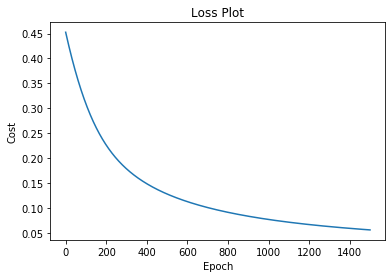

              |     GOLD LABELS               
              |     pos   |  neg     
Classifier pos|    12381  |  27          
Output     neg|    119    |  12473          
------------------------------
Model Accuracy :  99.416 %
Precision :  0.998
Recall    :  0.99
F1 score  :  0.994


In [461]:
alpha = 0.01
n_epoch = 1500
mode = 'batch'

parameters, cost_hist = logistic_regression(X_train, Y_train, alpha, n_epoch, mode)

print(mode,'Gradient Descent')
plt.plot(cost_hist)
plt.title('Loss Plot')
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.show()

model_evaluation(parameters,X_test,Y_test)

#### 3.2 Stochastic Gradient Descent

sgd Gradient Descent


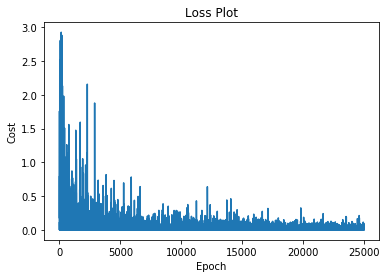

              |     GOLD LABELS               
              |     pos   |  neg     
Classifier pos|    12498  |  0          
Output     neg|    2    |  12500          
------------------------------
Model Accuracy :  99.992 %
Precision :  1.0
Recall    :  1.0
F1 score  :  1.0


In [468]:
alpha = 0.01
n_epoch = 1
mode = 'sgd'

parameters, cost_hist = logistic_regression(X_train, Y_train, alpha, n_epoch, mode)

print(mode,'Gradient Descent')
plt.plot(cost_hist)
plt.title('Loss Plot')
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.show()

model_evaluation(parameters,X_test,Y_test)